# Feature Selection and Validation Notebook
## Mental Health Text Classification
This notebook validates and selects features for mental health text classification using standard machine learning models, maintaining modularity and reproducibility throughout. Timing outputs mark the start and completion of each workflow stage for transparency.

## 1. Importing Libraries

In [77]:
import pandas as pd
import numpy as np
import time
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

notebook_start = time.time()
print("Notebook started")

Notebook started


## 2. Load Exported Feature Data

In [79]:
block_start = time.time()
print("Code start: Loading engineered features and text...")

df = pd.read_csv('features_interpretable.csv')
print(f"Loaded {df.shape[0]} samples, {df.shape[1]} columns.")
print("Columns:", list(df.columns))

print("Code finished: File loading in", round(time.time() - block_start, 2), "seconds.")


Code start: Loading engineered features and text...
Loaded 45261 samples, 21 columns.
Columns: ['Unique_ID', 'statement', 'status', 'text_length', 'word_count', 'num_urls', 'num_emojis', 'num_special_chars', 'num_excess_punct', 'avg_word_length', 'stopword_ratio', 'type_token_ratio', 'polarity', 'subjectivity', 'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio', 'has_suicidal_keyword', 'has_stress_keyword', 'has_help_keyword']
Code finished: File loading in 0.38 seconds.


## 3. Preprocess Boolean Features
Convert boolean flag columns to numeric format (0/1) to ensure compatibility with scikit-learn classifiers.

In [81]:
block_start = time.time()
print("Code start: Converting boolean columns to numeric...")

bool_cols = ['has_suicidal_keyword', 'has_stress_keyword', 'has_help_keyword']
for col in bool_cols:
    df[col] = df[col].map({'True': 1, 'False': 0, True: 1, False: 0})

print("Boolean columns converted to numeric.")
print("Code finished: Conversion in", round(time.time() - block_start, 2), "seconds.")


Code start: Converting boolean columns to numeric...
Boolean columns converted to numeric.
Code finished: Conversion in 0.02 seconds.


*Decision Note: Boolean features converted to numeric to prevent type errors during model training.*

## 4. Data Split for Validation
Partition the data into training and validation sets, using only engineered numeric features for classical machine learning. The text column is intentionally excluded from this split for models like Random Forest.

In [84]:
block_start = time.time()
print("Code start: Splitting into train and validation sets...")

text_col = 'statement'
target_col = 'status'
feature_cols = [col for col in df.columns if col not in ['Unique_ID', text_col, target_col]]

y = df[target_col]
X = df[feature_cols]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print("Train features:", X_train.shape, "| Validation features:", X_val.shape)

print("Code finished: Data split in", round(time.time() - block_start, 2), "seconds.")


Code start: Splitting into train and validation sets...
Train features: (36208, 18) | Validation features: (9053, 18)
Code finished: Data split in 0.04 seconds.


*Decision Note: Numeric features chosen as input for classical models; shuffling promotes fair validation and guards against data leakage.*

## 5. Feature Importance via Random Forest
Train a Random Forest classifier to rank the importance of each numeric feature. This process identifies which features contribute most to prediction accuracy.

In [87]:
block_start = time.time()
print("Code start: Evaluating feature importances with Random Forest...")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)
print("Top 10 features:")
print(top_features)

print("Code finished: Feature importance in", round(time.time() - block_start, 2), "seconds.")


Code start: Evaluating feature importances with Random Forest...
Top 10 features:
text_length         0.150111
type_token_ratio    0.113106
word_count          0.103570
avg_word_length     0.090148
stopword_ratio      0.075325
subjectivity        0.074823
polarity            0.073253
verb_ratio          0.071730
adj_ratio           0.071515
adv_ratio           0.048783
dtype: float64
Code finished: Feature importance in 6.18 seconds.


*Decision Note: Selected top 10 features based on importance; prioritized for validation.*

## 6. Model Validation
Evaluate performance using multiple classifiers on the selected features.

In [90]:
block_start = time.time()
print("Code start: Validating classifiers...")

X_train_sel = X_train[top_features.index]
X_val_sel = X_val[top_features.index]

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42)
}

results = {}
classes = np.unique(y_val)
y_val_bin = label_binarize(y_val, classes=classes)
n_classes = y_val_bin.shape[1]

for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_val_sel)
    y_prob = model.predict_proba(X_val_sel)
    acc = accuracy_score(y_val, y_pred)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val, y_pred))
    print(f"{name} Accuracy: {acc:.4f}")
    # Store results per model per class for ROC plotting
    results[name] = {'accuracy': acc, 'y_prob': y_prob}

print("Code finished: Classification in", round(time.time() - block_start, 2), "seconds.")

Code start: Validating classifiers...

Random Forest Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.43      0.16      0.23       621
             Bipolar       0.46      0.30      0.36       424
          Depression       0.45      0.64      0.53      2421
              Normal       0.77      0.89      0.83      3198
Personality disorder       0.93      0.25      0.39       158
              Stress       0.49      0.23      0.31       469
            Suicidal       0.38      0.25      0.30      1762

            accuracy                           0.58      9053
           macro avg       0.56      0.39      0.42      9053
        weighted avg       0.56      0.58      0.55      9053

Random Forest Accuracy: 0.5753

Logistic Regression Classification Report:


C:\Users\priya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\priya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\priya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

             Anxiety       0.32      0.01      0.02       621
             Bipolar       0.29      0.05      0.09       424
          Depression       0.39      0.70      0.50      2421
              Normal       0.70      0.90      0.79      3198
Personality disorder       0.00      0.00      0.00       158
              Stress       0.00      0.00      0.00       469
            Suicidal       0.36      0.09      0.15      1762

            accuracy                           0.53      9053
           macro avg       0.29      0.25      0.22      9053
        weighted avg       0.46      0.53      0.45      9053

Logistic Regression Accuracy: 0.5283

Gradient Boosting Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.27      0.04      0.07       621
             Bipolar       0.30      0.14      0.19       424
          Depression       0.42      0.68      0.

C:\Users\priya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

             Anxiety       0.00      0.00      0.00       621
             Bipolar       0.50      0.00      0.00       424
          Depression       0.39      0.80      0.53      2421
              Normal       0.73      0.91      0.81      3198
Personality disorder       0.00      0.00      0.00       158
              Stress       0.00      0.00      0.00       469
            Suicidal       0.39      0.03      0.06      1762

            accuracy                           0.54      9053
           macro avg       0.29      0.25      0.20      9053
        weighted avg       0.46      0.54      0.44      9053

SVM (RBF) Accuracy: 0.5409
Code finished: Classification in 521.94 seconds.


C:\Users\priya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\priya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


*Decision Note: Multi-model evaluation helps identify the best algorithm and guides hybrid modeling strategies.*

## 7. Visualization of Model Performance
Visualize accuracy comparison and ROC curves for all evaluated models.

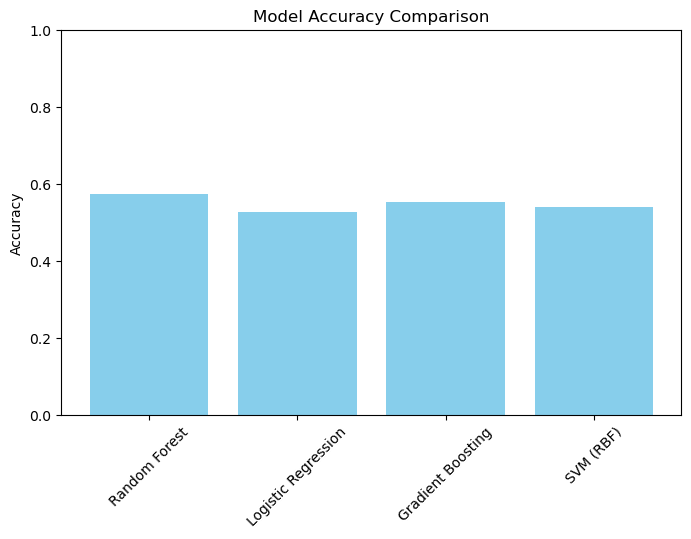

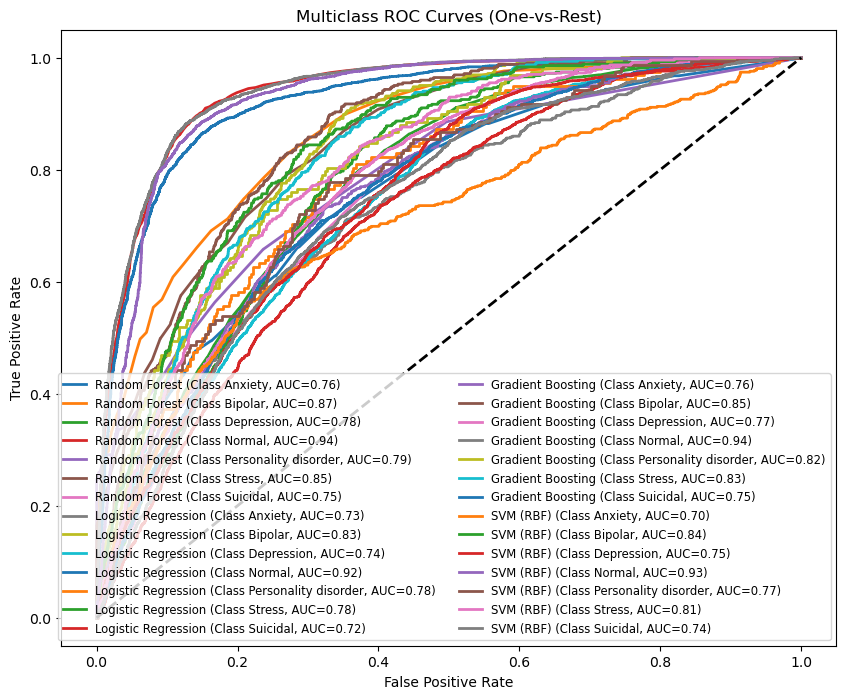

In [93]:
# Accuracy Bar Chart (unchanged)
plt.figure(figsize=(8,5))
names = list(results.keys())
accs = [results[n]['accuracy'] for n in names]
plt.bar(names, accs, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

# Multiclass ROC Curves through OvR approach
classes = np.unique(y_val)
y_val_bin = label_binarize(y_val, classes=classes)
plt.figure(figsize=(10,8))
for name in names:
    y_prob = results[name]['y_prob']
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (Class {class_label}, AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.show()

*Decision Note: Visual insights facilitate clear comparison and model selection.*

## 8. Interpretation and Finish
#### **Interpretation**  
Top features such as *text_length, type_token_ratio, word_count,* and *stopword_ratio* are most predictive. **Random Fores** and **Gradient Boosting** give the highest accuracy, but minority classes like Anxiety and Stress remain hard to classify due to imbalance.

#### **Finish**  
Retain these top features for **deeper/hybrid** modeling. Use **Random Forest** or **Gradient Boosting** as classical baselines. To improve weak class detection, plan for sampling or class weighting before deploying DistilBERT with this feature set.set.

In [96]:
print("Notebook finished")
print("Total execution time:", round(time.time() - notebook_start, 2), "seconds.")

Notebook finished
Total execution time: 530.51 seconds.
